In [7]:
from dotenv import load_dotenv
load_dotenv(r'.env')
import os
temp = os.environ.get('COMET_API_KEY')

In [6]:
# Importer comet_ml en haut de votre fichier, avant sklearn !
from comet_ml import Experiment

# Créer une expérience avec votre clé api
exp = Experiment(
    api_key=os.environ.get(temp),#ne pas coder en dur!
    project_name='milestone2',
    workspace='ift6758-a02',
)
# ... Faire de la science des données ...
exp.log_metrics({"auc": 12, "acc": 0.8, "loss": 0.65})


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a02/milestone2/9698eb944b8f4c95ae2ee66f31abf8db
COMET INFO:   Metrics:
COMET INFO:     acc  : 0.8
COMET INFO:     auc  : 12
COMET INFO:     loss : 0.65
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is l

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


## Ingénierie des caractéristiques I (10%)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Nettoyage des données

def clean_data(path) :
    """
    Nettoie un DataFrame de données de jeu NHL à partir d'un fichier JSON.

    Args:
        path (str): Le chemin vers le fichier JSON contenant les données de jeu NHL.

    Returns:
        pd.DataFrame: Un DataFrame propre contenant les colonnes 'emptyNet', 'isGoal',
                     'x', 'y', 'distanceToNet', et 'relativeAngleToNet'.

    """
    # Charger les données JSON en un DataFrame
    df = pd.read_json(path)

    # Extraire les informations des équipes, des événements de jeu et des résultats de jeu
    teamdf = df['gameData'].apply(pd.Series)['teams'].apply(pd.Series)
    df = df['liveData'].apply(pd.Series)['plays'].apply(pd.Series)['allPlays']
    df = pd.DataFrame(df)
    df = df.explode("allPlays")
    df = df.rename(columns={'allPlays': "play"})

    # Ajouter les noms des équipes 'awayTeam' et 'homeTeam'
    df['awayTeam'] = teamdf['away'].apply(pd.Series)['name']
    df['homeTeam'] = teamdf['home'].apply(pd.Series)['name']

    # Extraire les données d'événements 'play' pour obtenir les informations pertinentes
    df = df['play'].apply(pd.Series)
    df = pd.concat([df, df['result'].apply(pd.Series)], axis=1)

    # Filtrer les événements pour inclure uniquement 'Shot' et 'Goal'
    df = df[df['event'].isin(['Shot', 'Goal'])]

    # Extraire les coordonnées x et y des événements
    df['x'] = df['coordinates'].apply(pd.Series)['x']
    df['y'] = df['coordinates'].apply(pd.Series)['y']

    # Créer un nouveau DataFrame avec les colonnes pertinentes
    clean_df = df[['event','emptyNet','x','y']].copy()

    # Remplir les valeurs manquantes dans 'emptyNet' avec 0 et convertir en entier
    clean_df['emptyNet'] = clean_df['emptyNet'].fillna(0).astype(int)

    # Créer une nouvelle colonne 'isGoal' pour indiquer si l'événement est un but (1) ou non (0)
    clean_df['isGoal'] = (clean_df['event'] == 'Goal').astype(int)
    clean_df.drop('event',axis=1, inplace=True)

    # Suppréssion des valeurs manquantes 
    clean_df = clean_df.dropna()

    # Coordonnées des camps gauche et droit
    coord_camp_gauche = (-90, 0)
    coord_camp_droit = (90, 0)

    # Calculer la distance du joueur au filet en utilisant les coordonnées x et y
    clean_df['distanceToNet'] = np.sqrt(np.minimum((clean_df['x'] - coord_camp_gauche[0])**2 + (clean_df['y'] - coord_camp_gauche[1])**2, (clean_df['x'] - coord_camp_droit[0])**2 + (clean_df['y'] - coord_camp_droit[1])**2))
    
    # Calculer l'angle relatif du joueur par rapport au filet (filet gauche) et conversion en degre
    clean_df['relativeAngleToNet'] = np.degrees(np.arctan2(clean_df['y'], clean_df['x'] - coord_camp_gauche[0]))

    # Ajouter la colonne 'season' en extrayant l'année du chemin du fichier JSON
    clean_df['season'] = int(path[-9:-5])

    # Sauvegarder le DataFrame propre dans un fichier CSV
    clean_df.to_csv(path[:-5]+"_clean_M2.csv")



In [ ]:
# division des données en Ensemble de test et d'entrainement / validation

def split_data(path) :
    df = pd.read_csv(path)
    df.reset_index(drop=True, inplace=True)
    df = df.drop(columns=['Unnamed: 0.1'])
    
    train_data = df.loc[df['season'] != 2020]
    test_data = df.loc[df['season'] == 2020]

    test_data.reset_index(drop=True, inplace=True)

    train_data.to_csv("nhl_train_data.csv")
    test_data.to_csv("nhl_test_data.csv")

In [ ]:
# execution du code  (c'est long )
clean_data('nhl_data_2016.json') # ==> nouveau fichier nhl_data_2016_clean_M2.csv
clean_data('nhl_data_2017.json') # ==> nouveau fichier nhl_data_2017_clean_M2.csv
clean_data('nhl_data_2018.json') # ==> nouveau fichier nhl_data_2018_clean_M2.csv
clean_data('nhl_data_2019.json') # ==> nouveau fichier nhl_data_2019_clean_M2.csv
clean_data('nhl_data_2020.json') # ==> nouveau fichier nhl_data_2020_clean_M2.csv

p_clean = ["nhl_data_2016_clean_M2.csv","nhl_data_2017_clean_M2.csv", "nhl_data_2018_clean_M2.csv", "nhl_data_2019_clean_M2.csv", "nhl_data_2020_clean_M2.csv"]
df_list = []
count = 0
for path in p_clean:
    df = pd.read_csv(path)
    df_list.append(df)

    
df = pd.concat(df_list, axis=0, ignore_index=True)
df.to_csv('nhl_all_years_clean_M2.csv')

In [ ]:
split_data('nhl_all_years_clean_M2.csv') #==> deux fichiers : nhl_test_data.csv et nhl_train_data.csv

# Figures

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('data/nhl_train_data.csv')

1) histogramme des tirs regroupés par distance

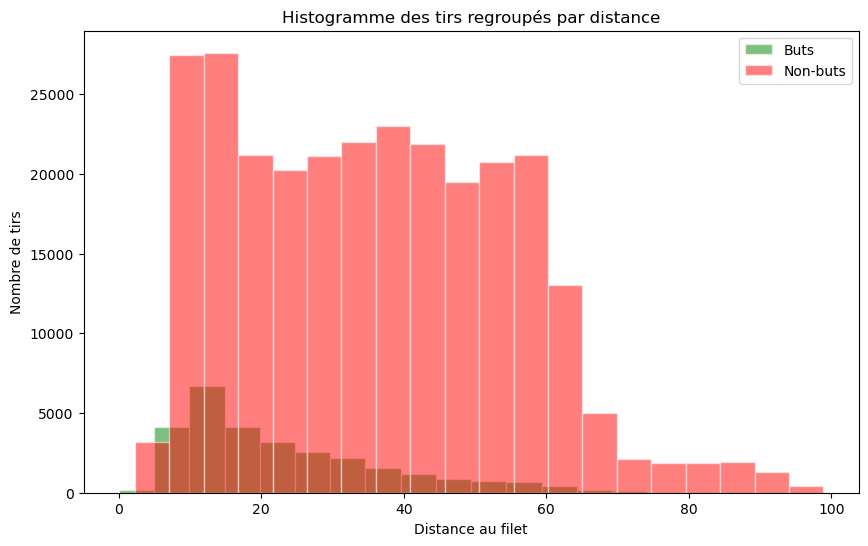

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['isGoal'] == 1]['distanceToNet'], bins=20, alpha=0.5, label='Buts', color='green', edgecolor = 'white')
plt.hist(df[df['isGoal'] == 0]['distanceToNet'], bins=20, alpha=0.5, label='Non-buts', color='red', edgecolor = 'white')

# Définir des titres et des légendes
plt.title('Histogramme des tirs regroupés par distance')
plt.xlabel('Distance au filet')
plt.ylabel('Nombre de tirs')
plt.legend()

# Afficher l'histogramme
plt.show()



2) histogramme des tirs regroupés par angle

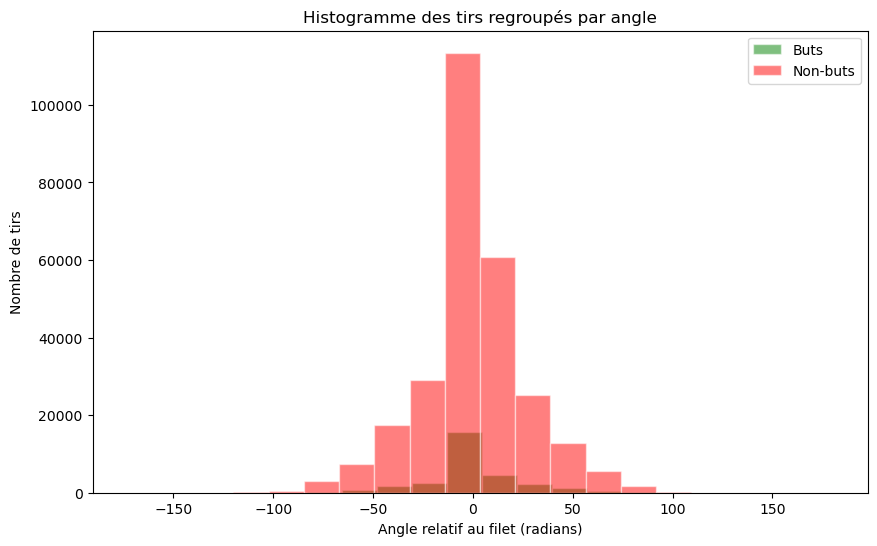

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['isGoal'] == 1]['relativeAngleToNet'], bins=20, alpha=0.5, label='Buts', color='green', edgecolor = 'white')
plt.hist(df[df['isGoal'] == 0]['relativeAngleToNet'], bins=20, alpha=0.5, label='Non-buts', color='red', edgecolor = 'white')

# Définir des titres et des légendes
plt.title("Histogramme des tirs regroupés par angle")
plt.xlabel("Angle relatif au filet (radians)")
plt.ylabel("Nombre de tirs")
plt.legend()

# Afficher l'histogramme
plt.show()

3) Histogramme 2D de la distance et de l'angle des tirs

/Users/aminatouseye/anaconda3/envs/DS-Milestone/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aminatouseye/anaconda3/envs/DS-Milestone/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aminatouseye/anaconda3/envs/DS-Milestone/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aminatouseye/anaconda3/envs/DS-Milestone/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

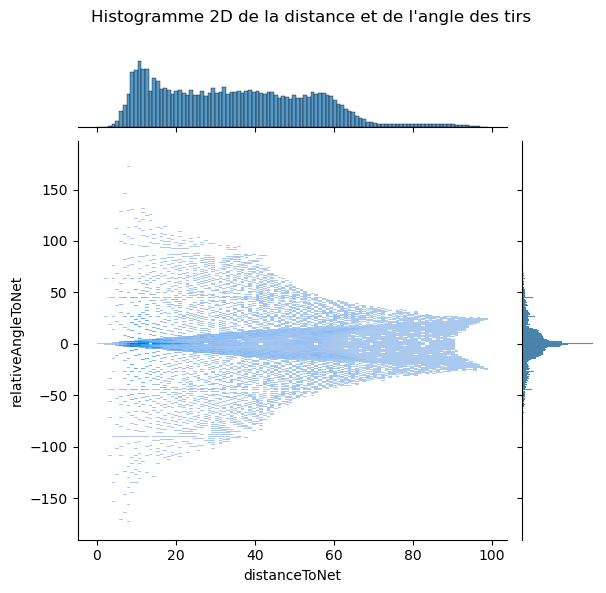

In [8]:
sns.jointplot(data=df, x="distanceToNet", y="relativeAngleToNet", kind="hist")

# Définir des titres et des légendes
plt.subplots_adjust(top=0.9)
plt.suptitle("Histogramme 2D de la distance et de l'angle des tirs")

# Afficher le joint plot
plt.show()


4) Taux de but en fonction de la distance (refaire)

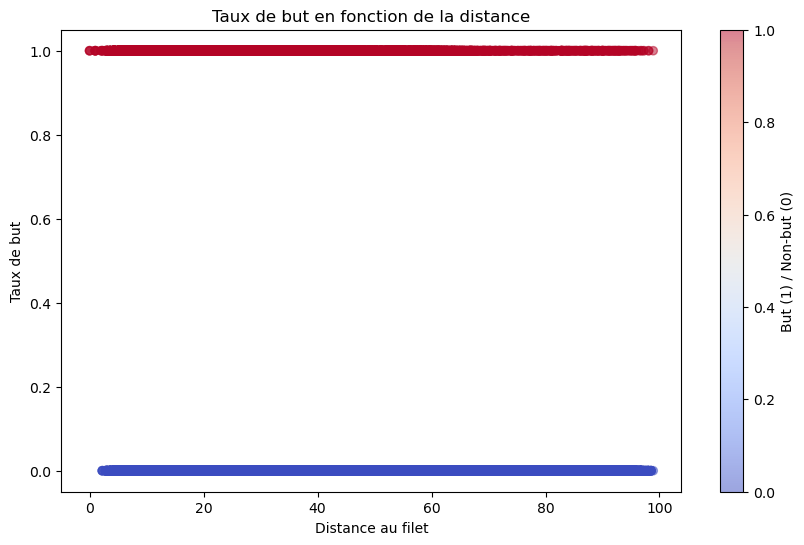

In [9]:
df['but_rate_distance'] = df['isGoal'] / (df['isGoal'] + (1 - df['isGoal']))

# Créer un nuage de points pour visualiser le taux de but en fonction de la distance
plt.figure(figsize=(10, 6))
plt.scatter(df['distanceToNet'], df['but_rate_distance'], alpha=0.5, c=df['isGoal'], cmap='coolwarm')

# Définir des titres et des légendes
plt.title("Taux de but en fonction de la distance")
plt.xlabel("Distance au filet")
plt.ylabel("Taux de but")
plt.colorbar(label="But (1) / Non-but (0)")

# Afficher le nuage de points
plt.show()

5) Histogramme des buts classés par distance

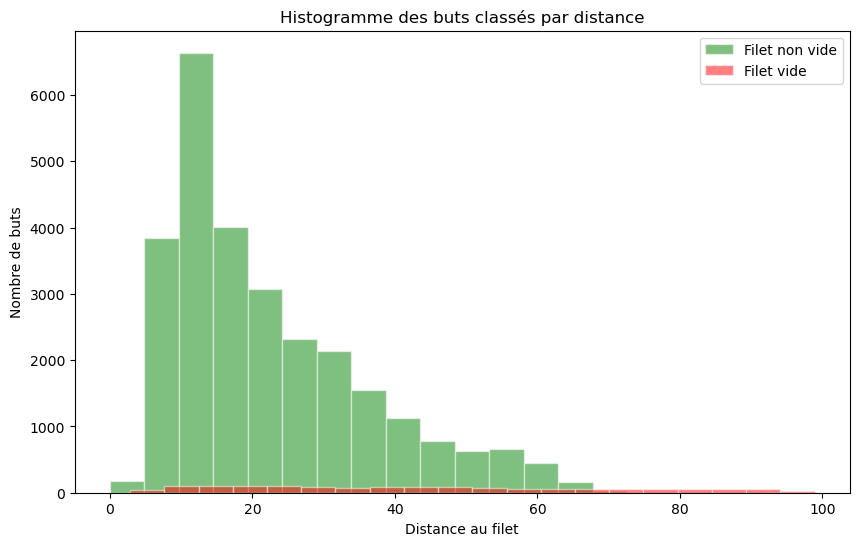

In [10]:
but_events = df[df['isGoal'] == 1]

# Créer un histogramme en séparant les événements nets vides et non vides
plt.figure(figsize=(10, 6))
plt.hist(but_events[but_events['emptyNet'] == 0]['distanceToNet'], bins=20, alpha=0.5, label='Filet non vide', color='green', edgecolor='white')
plt.hist(but_events[but_events['emptyNet'] == 1]['distanceToNet'], bins=20, alpha=0.5, label='Filet vide', color='red', edgecolor='white')

# Définir des titres et des légendes
plt.title("Histogramme des buts classés par distance")
plt.xlabel("Distance au filet")
plt.ylabel("Nombre de buts")
plt.legend()

# Afficher l'histogramme
plt.show()

## Modèles de base (15%)

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('data/nhl_train_data.csv')

In [4]:
# Sélection de la caractéristique de distance comme variable indépendante (X) et la cible (isGoal) comme variable dépendante (y)
X = df[['distanceToNet']]
y = df['isGoal']

# Division des données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement d'un classifieur de regressiom logistique
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
y_pred = clf.predict(X_valid)

# Calcul de l'accuracy du modèle
accuracy = accuracy_score(y_valid, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")


/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-pack

Précision du modèle : 0.91


/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-pack

/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-pack

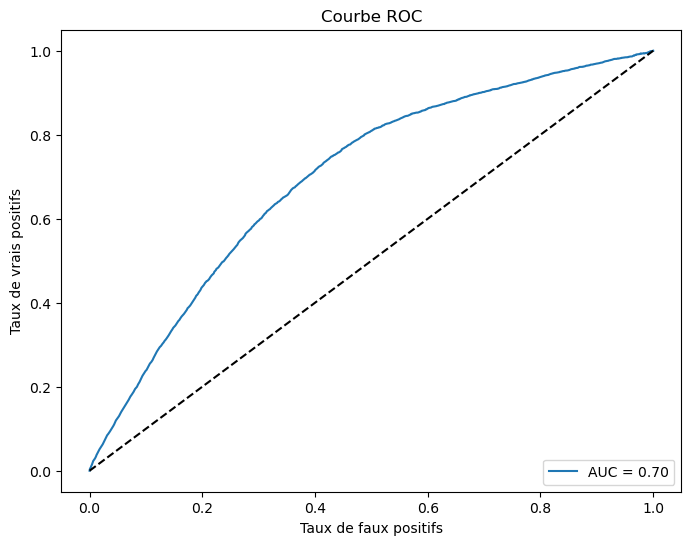

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculer les probabilités prédites
y_prob = clf.predict_proba(X_valid)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)

# Calculer l'AUC
auc = roc_auc_score(y_valid, y_prob)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/_9/frm569j918z_mqddtqqtgym40000gn/T/ipykernel_2819/3484360695.py:15:

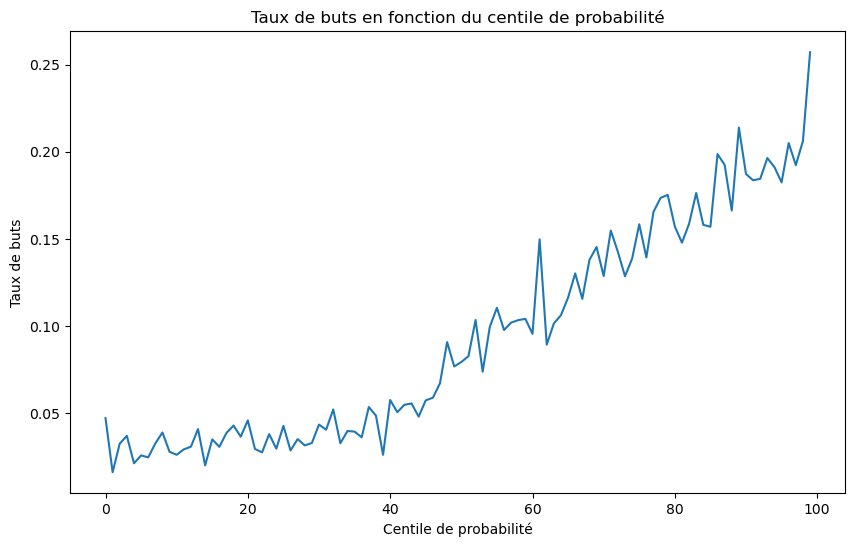

In [6]:
# Calculer les probabilités prédites
y_prob = clf.predict_proba(X_valid)[:, 1]

import pandas as pd

# Créer un DataFrame avec les probabilités et les étiquettes réelles
prob_df = pd.DataFrame({'Probabilite': y_prob, 'isGoal': y_valid})

prob_df = prob_df.sort_values(by='Probabilite')

# Ajouter une colonne 'Centile' au DataFrame
prob_df['Centile'] = pd.qcut(prob_df['Probabilite'], q=100)

# Calculer le taux de buts pour chaque centile
goal_rate_by_centile = prob_df.groupby('Centile')['isGoal'].mean()


# Convertir l'index en pourcentage pour représenter le centile
percentiles = goal_rate_by_centile.index.codes / len(goal_rate_by_centile.index.categories) * 100

# Tracer le taux de buts en fonction du centile
plt.figure(figsize=(10, 6))
plt.plot(percentiles, goal_rate_by_centile.values)
plt.xlabel('Centile de probabilité')
plt.ylabel('Taux de buts')
plt.title('Taux de buts en fonction du centile de probabilité')
plt.show()

In [12]:
print("Shape of percentiles:", percentiles.shape)
print("Shape of cumulative_goal_proportion.values:", cumulative_goal_proportion.values.shape)


Shape of percentiles: (100,)
Shape of cumulative_goal_proportion.values: (61160,)


/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/_9/frm569j918z_mqddtqqtgym40000gn/T/ipykernel_2819/3878661231.py:14:

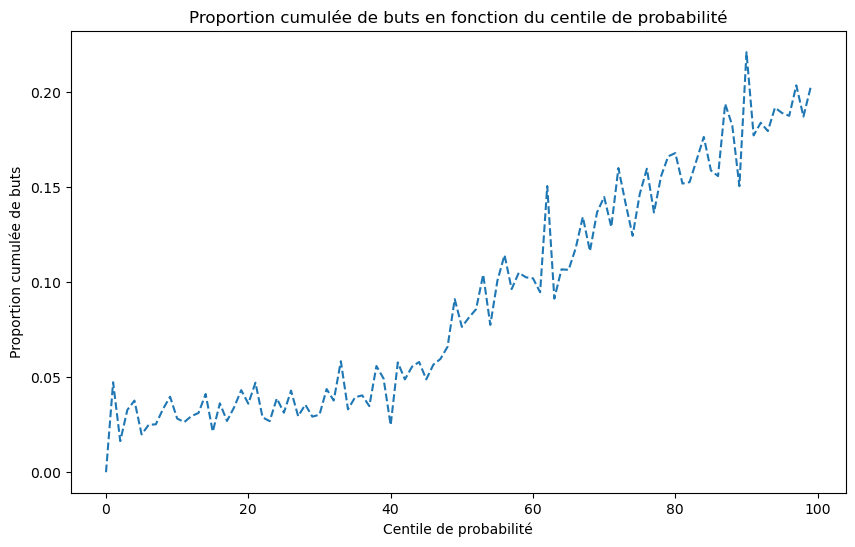

In [13]:
# Calcul des probabilités prédites
y_prob = clf.predict_proba(X_valid)[:, 1]

# Création du DataFrame avec probabilités et étiquettes réelles
prob_df = pd.DataFrame({'Probabilite': y_prob, 'isGoal': y_valid})

# Tri du DataFrame par ordre croissant des probabilités
prob_df = prob_df.sort_values(by='Probabilite')

# Ajout de la colonne 'Centile' au DataFrame
prob_df['Centile'] = pd.qcut(prob_df['Probabilite'], q=100)

# Calcul du nombre cumulatif de buts et non-buts pour chaque centile
cumulative_goals = prob_df.groupby('Centile')['isGoal'].cumsum()
cumulative_shots = prob_df.groupby('Centile').cumcount() + 1

# Calcul de la proportion cumulée de buts et non-buts pour chaque centile
cumulative_goal_proportion = cumulative_goals / cumulative_shots
cumulative_non_goal_proportion = 1 - cumulative_goal_proportion



resampled_cumulative_goal_proportion = np.interp(percentiles, np.linspace(0, 100, len(cumulative_goal_proportion.values)), cumulative_goal_proportion.values)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, resampled_cumulative_goal_proportion, label='Buts', linestyle='--')
plt.xlabel('Centile de probabilité')
plt.ylabel('Proportion cumulée de buts')
plt.title('Proportion cumulée de buts en fonction du centile de probabilité')
plt.show()



/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-pack

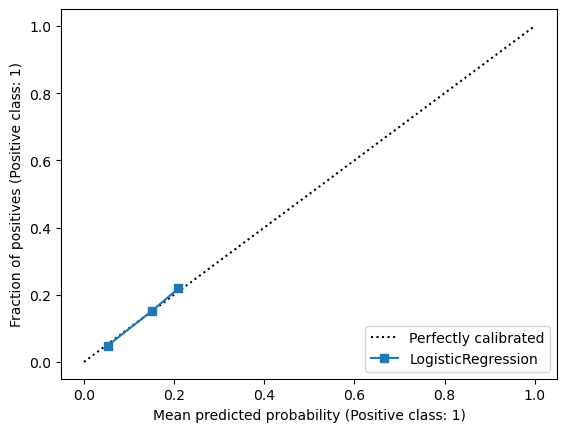

<Figure size 1000x600 with 0 Axes>

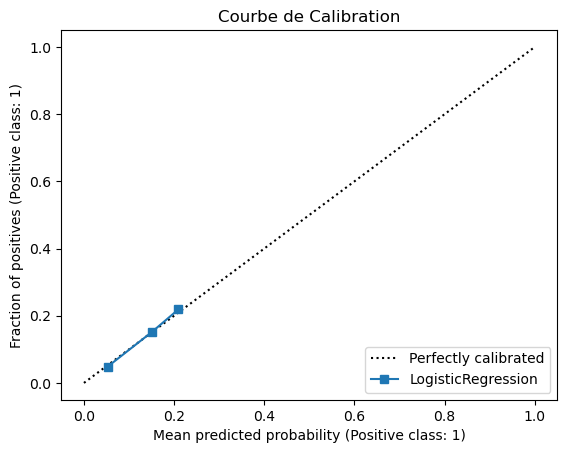

In [8]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Calculer les probabilités prédites
y_prob = clf.predict_proba(X_valid)[:, 1]

# Obtenir la courbe de calibration
prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=10, strategy='uniform')

# Créer un objet CalibrationDisplay
calibration_display = CalibrationDisplay.from_estimator(clf, X_valid, y_valid, n_bins=10)

# Afficher la courbe de calibration
plt.figure(figsize=(10, 6))
calibration_display.plot()
plt.title('Courbe de Calibration')
plt.show()


/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-pack

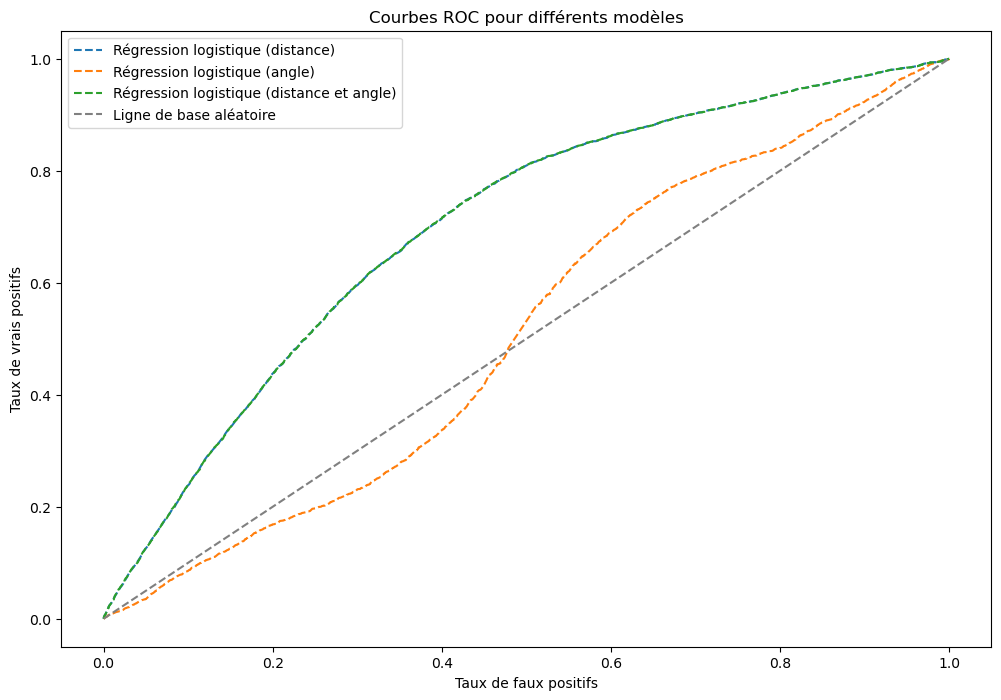

/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-pack

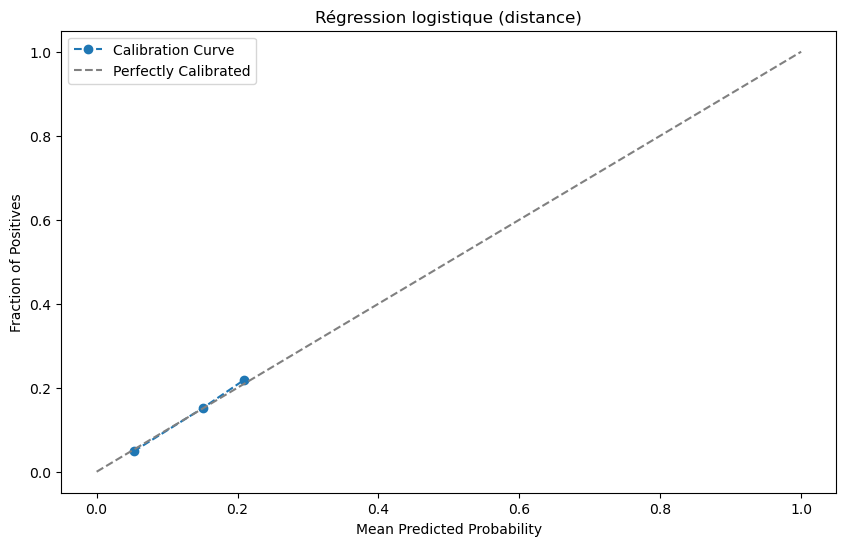

/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-pack

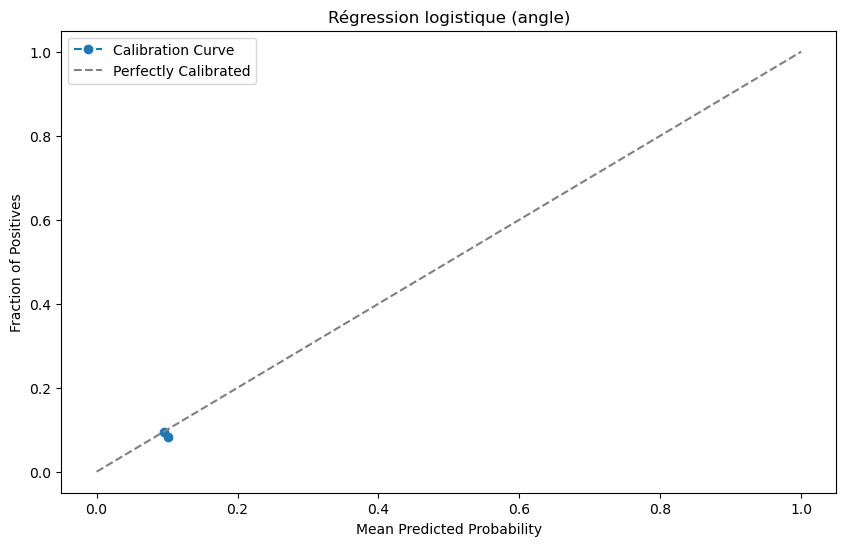

/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aminatouseye/anaconda3/envs/MachineLearningKaggle/lib/python3.11/site-pack

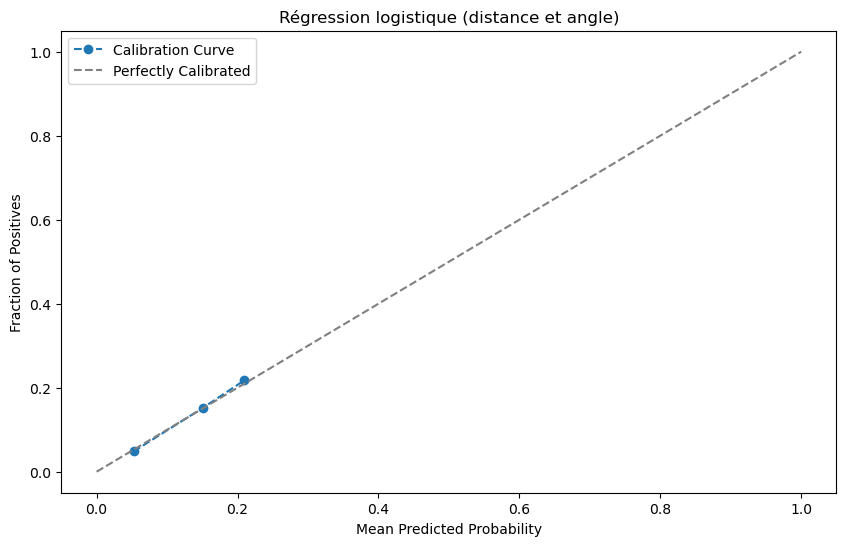

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('data/nhl_train_data.csv')

# Diviser les données en ensembles d'entraînement et de validation
X_distance = df[['distanceToNet']]
X_angle = df[['relativeAngleToNet']]
X_distance_angle = df[['distanceToNet', 'relativeAngleToNet']]
y = df['isGoal']

X_train_distance, X_valid_distance, y_train, y_valid = train_test_split(X_distance, y, test_size=0.2, random_state=42)
X_train_angle, X_valid_angle, _, _ = train_test_split(X_angle, y, test_size=0.2, random_state=42)
X_train_distance_angle, X_valid_distance_angle, _, _ = train_test_split(X_distance_angle, y, test_size=0.2, random_state=42)

# Entraîner les modèles
clf_distance = LogisticRegression()
clf_distance.fit(X_train_distance, y_train)

clf_angle = LogisticRegression()
clf_angle.fit(X_train_angle, y_train)

clf_distance_angle = LogisticRegression()
clf_distance_angle.fit(X_train_distance_angle, y_train)

# Prédire les probabilités sur l'ensemble de validation
y_prob_distance = clf_distance.predict_proba(X_valid_distance)[:, 1]
y_prob_angle = clf_angle.predict_proba(X_valid_angle)[:, 1]
y_prob_distance_angle = clf_distance_angle.predict_proba(X_valid_distance_angle)[:, 1]

# ROC et AUC
fpr_distance, tpr_distance, _ = roc_curve(y_valid, y_prob_distance)
fpr_angle, tpr_angle, _ = roc_curve(y_valid, y_prob_angle)
fpr_distance_angle, tpr_distance_angle, _ = roc_curve(y_valid, y_prob_distance_angle)

plt.figure(figsize=(12, 8))
plt.plot(fpr_distance, tpr_distance, label='Régression logistique (distance)', linestyle='--')
plt.plot(fpr_angle, tpr_angle, label='Régression logistique (angle)', linestyle='--')
plt.plot(fpr_distance_angle, tpr_distance_angle, label='Régression logistique (distance et angle)', linestyle='--')

# Ligne de base aléatoire
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ligne de base aléatoire')

plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC pour différents modèles')
plt.legend()
plt.show()


def plot_calibration_curve(clf, X, y, title):
    y_prob = clf.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10, strategy='uniform')
    
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', linestyle='--', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(title)
    plt.legend()
    plt.show()


# Taux de but en fonction du centile de la probabilité
plot_calibration_curve(clf_distance, X_valid_distance, y_valid, 'Régression logistique (distance)')

plot_calibration_curve(clf_angle, X_valid_angle, y_valid, 'Régression logistique (angle)')

plot_calibration_curve(clf_distance_angle, X_valid_distance_angle, y_valid, 'Régression logistique (distance et angle)')


Discussion a ajouter dans le blogpost : ...

## 4. Ingenierie des caracteristiques II (15%)

In [ ]:
import pandas as pd
import numpy as np
import datetime

#Helper Function
def role(z):
  shooter = []
  assist = []
  guardian = []

  for player in z:
    if player['playerType'] in ["Shooter", 'Scorer']:
      shooter.append((player['player']['fullName'], player['player']['id']))
    elif player['playerType'] == 'Assist':
      assist.append((player['player']['fullName'], player['player']['id']))
    elif player['playerType'] == 'Goalie':
      guardian.append((player['player']['fullName'], player['player']['id']))
    else:
      print("new player type: "+ player['playerType'])
  if len(guardian) == 0:
    guardian = ("Empty", 0)
  else:
    guardian = guardian[0]
  return [shooter, assist, guardian]


def stringCoordx(strCoord):
  l = strCoord.split(",")
  return float(l[0].split(" ")[-1])

def stringCoordy(strCoord):
  l = strCoord.split(",")
  return float(l[1].split(" ")[-1][:-1])


def clean_with_PreviousEvent(json_path):
    """
    json_path: path vers le fichier json

    clean et sauvegarde un df clean
    """
    df = pd.read_json(json_path)

    teamdf = df['gameData'].apply(pd.Series)['teams'].apply(pd.Series)

    df = df['liveData'].apply(pd.Series)['plays'].apply(pd.Series)['allPlays']
    df = pd.DataFrame(df)
    df = df.explode("allPlays")
    df = df.rename(columns={'allPlays': "play"})

    #add the wayTeam & homeTeam columns
    df['awayTeam'] = teamdf['away'].apply(pd.Series)['name']
    df['homeTeam'] = teamdf['home'].apply(pd.Series)['name']

    df = df['play'].apply(pd.Series)
    df = pd.concat([df, df['result'].apply(pd.Series)], axis=1)
    df = df.drop('result', axis=1)
    df = pd.concat([df, df['about'].apply(pd.Series)], axis=1)
    df = df.drop('about', axis=1)
    df['previousEventTypeId'] = df['eventTypeId'].shift(1)
    df.loc[df['eventId'] == 1, 'previousEventTypeId'] = None
    df['previousDescription'] = df['description'].shift(1)
    df.loc[df['eventId'] == 1, 'previousDescription'] = None
    df['previousCoordinates'] = df['coordinates'].shift(1)
    df.loc[df['eventId'] == 1, 'previousCoordinates'] = None
    df['previousPeriod'] = df['period'].shift(1)
    df.loc[df['eventId'] == 1, 'previousPeriod'] = None
    df['previousPeriodTime'] = df['periodTime'].shift(1)
    df.loc[df['eventId'] == 1, 'previousPeriodTime'] = None
    df['previousDateTime'] = df['dateTime'].shift(1)
    df.loc[df['eventId'] == 1, 'previousDateTime'] = None
    df = df[df['event'].isin(['Shot', 'Goal'])]

    df_inbetween = df[[ 'dateTime', 'period', 'periodTime', 'event', 'eventTypeId', 'eventId', 'description',  'team', 'secondaryType', 'strength', 'coordinates', 'goals', 'previousEventTypeId', 'previousDescription', 'previousCoordinates', 'previousPeriod', 'previousPeriodTime', 'previousDateTime']].copy()
    df_inbetween = pd.concat([df_inbetween, df_inbetween['team'].apply(pd.Series).iloc[:,[1,3]]], axis=1)
    df_inbetween = pd.concat([df_inbetween, df['players'].apply(role).apply(pd.Series)], axis=1)
    df_inbetween = df_inbetween.rename(columns={0: "tireur/ID", 1: "assist/ID", 2: "guardian/ID", 'name': 'attackingTeamName', 'triCode': 'attackingTeamTriCode', 'secondaryType': 'typeDeTir', 'goals': 'scoreAfterShot'})
    df_inbetween = df_inbetween.drop('team', axis=1)
    df_inbetween['emptyNet'] = pd.Series(np.where(df_inbetween['guardian/ID'] ==("Empty", 0), True, False))
    df_inbetween = df_inbetween.rename(columns={"Unnamed: 0": 'matchNum'})
    df_inbetween = pd.concat([df_inbetween, df_inbetween['coordinates'].apply(lambda x: pd.Series(x, dtype=np.float64))], axis=1)

    #drop some columns columns
    df = df_inbetween[['dateTime', 'period', 'periodTime', 'eventTypeId', 'description', 'x', 'y', 'previousEventTypeId', 'previousCoordinates', 'previousPeriodTime', 'previousDateTime']]
    # Coordonnées des camps gauche et droit
    coord_camp_gauche = (-90, 0)
    coord_camp_droit = (90, 0)

    df['distanceToNet'] = np.sqrt(np.minimum((df['x'] - coord_camp_gauche[0])**2 + (df['y'] - coord_camp_gauche[1])**2, (df['x'] - coord_camp_droit[0])**2 + (df['y'] - coord_camp_droit[1])**2))

    # Calculer l'angle relatif du joueur par rapport au filet (filet gauche)
    df['relativeAngleToNet'] = np.degrees(np.arctan2(df['y'], df['x'] - coord_camp_gauche[0]))

    df = pd.concat([df, df['previousCoordinates'].apply(lambda x: pd.Series(x, dtype=np.float64))], axis=1)
    #rename previous X and Y
    df.columns = np.concatenate([np.array(df.columns[:-2]), ['previousX', 'previousY']])

    #drop NaN rows
    df = df.dropna(subset=['x', 'y'])
    #drop obsolete previousCoordinates columns
    df = df.drop('previousCoordinates', axis=1)
    #calculate distance from previous event
    df['distanceFromPrevious'] = round(np.sqrt((df['x']-df['previousX'])**2+(df['y']-df['previousY'])**2), 2)
    #calculate timeDiff
    time_format = "%M:%S"
    df['timeDiff'] = (pd.to_datetime(df['periodTime'], format=time_format) - pd.to_datetime(df['previousPeriodTime'], format=time_format)).dt.total_seconds().astype(int)
    #cree rebond
    df['rebond'] = df['previousEventTypeId'] == 'SHOT'
    #cree vitess
    df['vitesse'] = df['distanceFromPrevious']/df['timeDiff']
    # Calculer l'angle relatif du joueur par rapport au filet (filet gauche)
    df['previousRelativeAngleToNet'] = np.degrees(np.arctan2(df['previousY'], df['previousX'] - coord_camp_gauche[0]))
    #cree angleChange
    df['angleChange'] = np.abs(df['relativeAngleToNet']-df['previousRelativeAngleToNet'])
    df.loc[df['rebond'] == False, 'angleChange'] = 0.0

    #cree le df final
    final = df[['dateTime', 'period', 'periodTime', 'eventTypeId', 'description', 'x', 'y', 'distanceToNet', 'relativeAngleToNet', 'previousEventTypeId', 'previousX', 'previousY', 'distanceFromPrevious', 'timeDiff', 'rebond', 'angleChange','vitesse' ]]

    final['season'] = int(json_path[-9:-5])

    final.to_csv(json_path[:-5]+"_previous.csv")


In [ ]:
#iterate over all nhl_data files and make a clean df
p = ["nhl_data_2016.json", "nhl_data_2017.json", "nhl_data_2018.json", "nhl_data_2019.json", "nhl_data_2020.json"]
for file_path in p:
    clean_with_PreviousEvent(file_path)

In [ ]:
#merge all the clean df into one
p_previous = ["nhl_data_2016_previous.csv","nhl_data_2017_previous.csv", "nhl_data_2018_previous.csv", "nhl_data_2019_previous.csv"]
df_list = []
count = 0
for path in p_previous:
    df = pd.read_csv(path)
    df['Unnamed: 0'] = df['Unnamed: 0']+count
    count = df['Unnamed: 0'].values[-1]
    df_list.append(df)
df = pd.concat(df_list, axis=0, ignore_index=True)
df.to_csv('nhl_2016to2019_previous.csv')